In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from datetime import datetime

## Functions
Here we have defined all the useful functions to accomplish the request

In [2]:
def orario(lista):
    lista = [datetime.strptime(t, '%H:%M:%S') for t in lista]
    sec_1 = []
    min_1 = []
    ora_1 = []
    number_review = []
    for i in range(len(lista)):
        sec_1.append(lista[i].time().second)
        min_1.append(lista[i].time().minute)
        ora_1.append(lista[i].time().hour)
    for i in range(0, len(lista), 2):
        number_review.append(dataset[(dataset.timestamp_created.dt.hour >= ora_1[i]) & \
                                     (dataset.timestamp_created.dt.minute >= min_1[i]) & \
                                     (dataset.timestamp_created.dt.second >= sec_1[i]) & \
                                     (dataset.timestamp_created.dt.hour <= ora_1[i+1]) &\
                                     (dataset.timestamp_created.dt.minute <= min_1[i+1]) & \
                                     (dataset.timestamp_created.dt.second <= sec_1[i+1])].review_id.count())
    
    xx = []
    for i in range(0,len(ora_1),2):
        xx.append(str(ora_1[i]))
    #xx = ['6am', '11am', '2pm', '5pm', '8pm', '12am', '3am']
    plt.bar(xx, number_review, color = 'salmon')
    plt.yscale('log')
    plt.yticks([2000000, 2500000, 3000000, 3500000, 4000000])
    plt.title('Number of review for each interval of time')
    plt.xlabel('Intervals')
    plt.ylabel('Number of review')
    plt.show()

In [3]:
def parsedate(time_as_a_unix_timestamp):
    return pd.to_datetime(time_as_a_unix_timestamp, unit = 's')

In [4]:
def filtro(data, lingue):
    a = pd.DataFrame(columns = dataset.columns)
    for i in range(len(lingue)):
        a = pd.concat([a, data[data.language == lingue[i]]])
    return a

# Load the dataset
we load our dataset and using the function **parsedate** we have changed the format of our timestamp

In [5]:
dataset = pd.read_csv('steam_reviews.csv')

In [6]:
dataset = pd.read_csv('steam_reviews.csv', header='infer',
parse_dates=['timestamp_created',
'timestamp_updated', 'author.last_played'],
date_parser = parsedate)

In [6]:
dataset.columns

Index(['Unnamed: 0', 'app_id', 'app_name', 'review_id', 'language', 'review',
       'timestamp_created', 'timestamp_updated', 'recommended',
       'votes_helpful', 'votes_funny', 'weighted_vote_score', 'comment_count',
       'steam_purchase', 'received_for_free', 'written_during_early_access',
       'author.steamid', 'author.num_games_owned', 'author.num_reviews',
       'author.playtime_forever', 'author.playtime_last_two_weeks',
       'author.playtime_at_review', 'author.last_played'],
      dtype='object')

In [7]:
dataset.shape

(21747371, 23)

# RQ1

###  Exploratory Data Analysis (EDA)

To try to better understand our dataset we have made a bunch of plots and tables in which we have tried to catch some information about these reviews received for the applications in Steam.

#### Application more reviewed: 
To start our analysis we have made a pie chart about applications more reviewed. In particular we have decided to pick the first thirty games more reviewed and understand how the number of rewiews is splitted between them. Indeed the percentage written in the slices of the pie plot is referred not to the total number of reviews but the to the sum of reviews written for these thirty more popular games. The choice of thirty is due to make cleaner the plot and because we are interested only in the more popular games. The most talked-about.

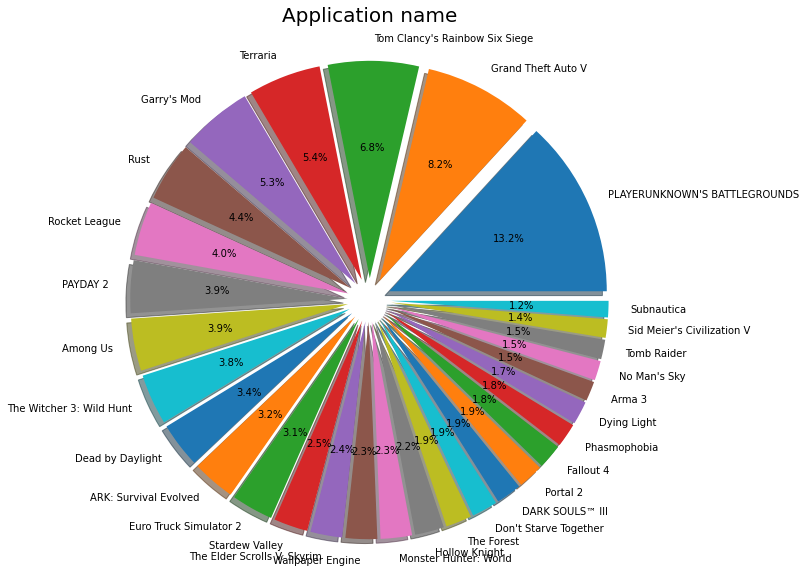

In [13]:
a = pd.Series(dataset.groupby("app_name").app_id.count().sort_values(ascending=False).head(30))
plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(a,
labels = a.index,
explode = [0.1 for value in range(0, a.index.nunique())],
shadow = True, autopct = '%.1f%%')
plt.title('Application name', fontsize = 20)
plt.axis('off')
plt.show()

#### Correlation matrix:
Then we have tried to make a correlation matrix to understand if there are some variables correlated between them 

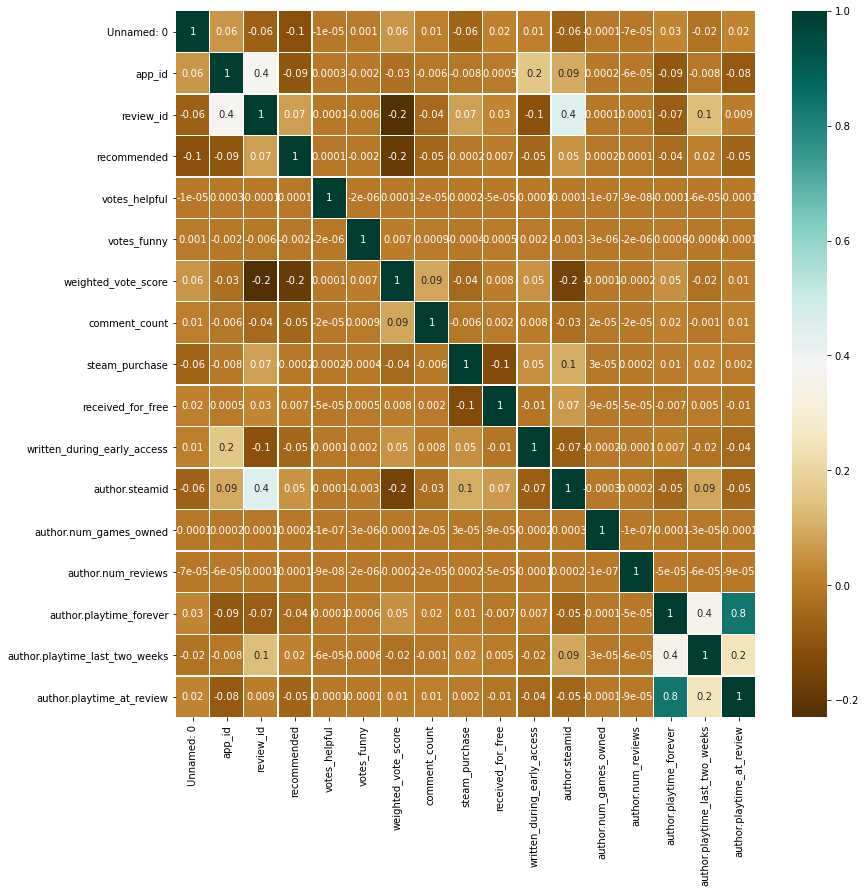

In [62]:
fig, ax = plt.subplots(figsize=(13,13)) 
sns.heatmap(dataset.corr(), cbar=True, annot = True, cmap='BrBG', linewidths=.3,fmt='.1g')

We have noticed that there was not any particular correlation between columns except for the ones related to time played by the player therefore we have decided to see in depth these correlations to have clearer information about them. 

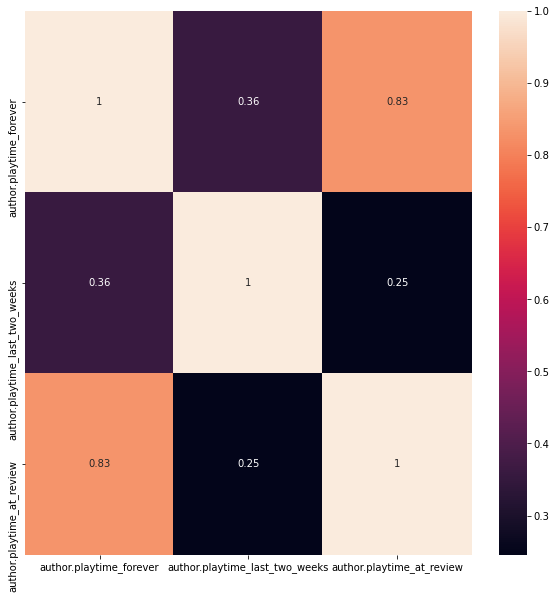

In [18]:
df = pd.DataFrame(dataset,columns=['author.playtime_forever','author.playtime_last_two_weeks',\
                                   'author.playtime_at_review'])
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()


#### Time and Language:
At this point we want to extract some information about the language of the reviews and time when they were written. We have divided the day in three parts: morning (8am-2pm), afternoon (2pm-10pm) and night (10pm-8am). 
So for each part of the day we have grouped the reviews by language, counted them and picked the ten languages more popular.

In this way in our final barplot for each popular language we have the number of reviews written in each part of the day. We have also made a table to explain better the number obtained. 

In [51]:
arr_1 = np.array((dataset['timestamp_created'].dt.time.astype('str') >= "08:00:00")& (dataset['timestamp_created'].dt.time.astype('str') <= "13:59:59"))
arr_2 = np.array((dataset['timestamp_created'].dt.time.astype('str') >= "14:00:00")& (dataset['timestamp_created'].dt.time.astype('str') <= "21:59:59"))
arr_3 = np.array((dataset['timestamp_created'].dt.time.astype('str') >= "22:00:00")& (dataset['timestamp_created'].dt.time.astype('str') <= "7:59:59"))




In [52]:
mattina = pd.Series(dataset[arr_1].groupby("language").language.count().sort_values(ascending=False).head(10))
pomeriggio = pd.Series(dataset[arr_2].groupby("language").language.count().sort_values(ascending=False).head(10))
notte = pd.Series(dataset[arr_3].groupby("language").language.count().sort_values(ascending=False).head(10))

In [53]:
df = mattina.to_frame(name = "8am-2pm")
df["2pm-10pm"]=pomeriggio
df["10pm-8am"]=notte
df['language'] = df.index


In [54]:
df.set_index(["language"], drop = True)

,8am-2pm,2pm-10pm,10pm-8am
language,,,
english,1723581,3818056,985860
schinese,1426672,916148,66048
russian,777649,1099378,99067
koreana,238303,157217,17927
german,202319,418566,59610
turkish,188734,327833,44820
polish,148353,270651,35193
french,143964,281877,48927
spanish,107991,345728,98602


Text(0, 0.5, 'number reviews')

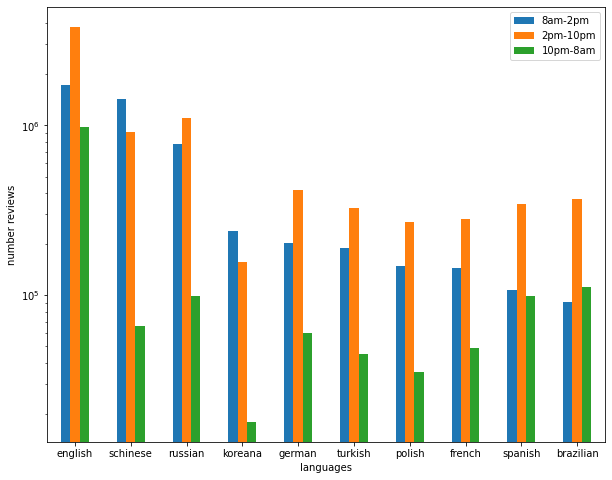

In [36]:
ax = df.plot(x = "language", kind ='bar', stacked = False, figsize =(10,8), alpha=1, rot=0)
ax.set_yscale('log')
ax.set_xlabel('languages')
ax.set_ylabel("number reviews")

In this stacked barplot we can see that the majority of the reviews are written during the afternoon while during the night fewer people usually write on Steam. The language more used as expected is English

#### Viral Comments:
In this table we have wanted to look at the ten reviews which have received more comments because we have thought that it could be interesting look at them to understand which comments are popular on Steam. 

In [57]:
dataset_7 = dataset.sort_values(by=['comment_count'], ascending = False)
dataset_7 = dataset_7.reset_index()

In [60]:
dataset_7[["author.steamid", "language", "review", "comment_count"]].head(10)

,author.steamid,language,review,comment_count
0,76561198094505831,schinese,辣鸡游戏,4893
1,76561198144481578,english,"Overhyped, poorly optimized, indie game made b...",1432
2,76561198348751745,schinese,蓝洞韩国杂总，国家就是一帮垃圾民族组成的狗杂种，这个垃圾民族就该死绝死光，杀绝种了，杂种民族...,1235
3,76561198301678331,schinese,比全球首发版还贵…当中国人傻钱多么？\n\n------------------------...,1143
4,76561198041275847,english,People have demonstrated consistently since Fa...,1034
5,76561197976628085,english,tl;dr\nFallout 4 is a huge leap backwards from...,1026
6,76561198253235623,schinese,2020.2.6\n新冠期间涌入大量狼友，所以更新了一下\n1.更新了失效的网盘链接\n2....,929
7,76561198819827956,schinese,去兔子补丁3.0 可以去dlc （拿到的点赞 顶我上去！）\n链接：pan.删除ba...,880
8,76561198078772275,russian,[h1] Они не хотят уничтожить нас. \nОни хотят ...,810
9,76561198027414971,english,"I love this game, I built a house around a guy...",779


Unfortunately the majority of them are written not in english!

#### Games more played:
In our dataset there is a column in which is stored the time played by that player to that particular game. So we have decided to explore what are the games more played in terms of hours. We have decided to pick the top 20 games because we have thought that 20 is a good trade-off between a clear plot and a meaningful number of games. 

In [92]:
#dataset_8 = dataset_8[["author.steamid", "author.playtime_forever","app_name"]]
dataset_8 = pd.Series(dataset.groupby("app_name")["author.playtime_forever"].sum().sort_values(ascending=False))
ore_di_gioco = dataset_8.values
giochi = dataset_8.index

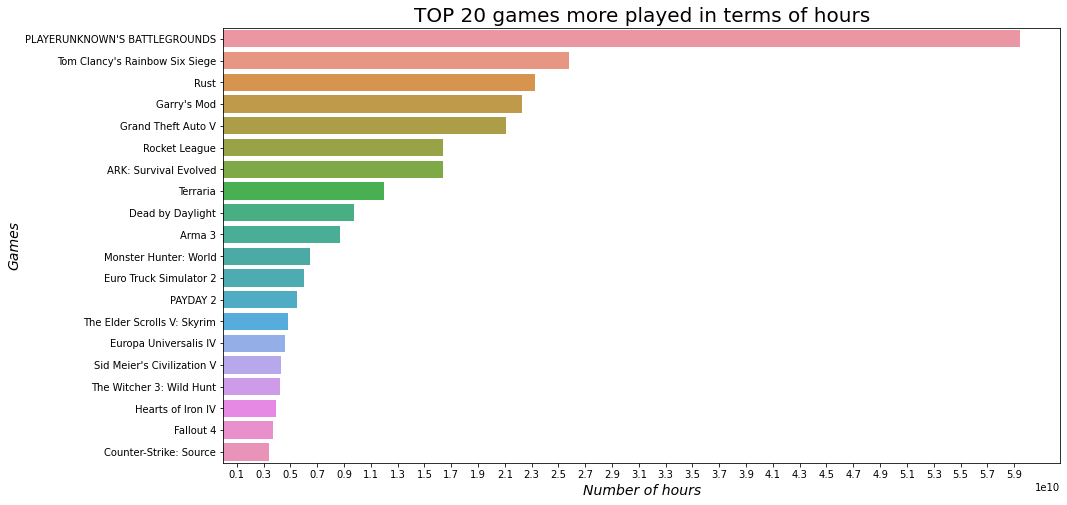

In [121]:
plt.figure(figsize = ((15, 8)))
sns.barplot(x = ore_di_gioco[:20], 
            y = giochi[:20], orient = 'h')
plt.title('TOP 20 games more played in terms of hours', size = 20)
plt.ylabel('Games', size = 14, style = 'italic')
plt.xlabel('Number of hours', size = 14, style = 'italic')
#plt.xscale('log')
plt.xticks(np.arange(1000000000,60000000000,2000000000)) 
plt.show()

In this barplot we have found some confirms: the games more played are also often the games more reviewed that were appeared in the pie chart.

#### Active players:
To conclude this first analysis we have tried to understand what are the players more useful for Steam: we have selected the ten authors that have written the most number of helpful and funny reviews. 

In [3]:
dataset_9 = pd.Series(dataset[(dataset.votes_helpful > 0)].groupby("author.steamid").votes_helpful.count().sort_values(ascending=False))

dataset_10 = pd.Series(dataset[(dataset.votes_funny > 0)].groupby("author.steamid").votes_funny.count().sort_values(ascending=False))





In [4]:
pd.concat([dataset_9[:11], dataset_10[:11]], axis=1).reset_index().fillna(0).sort_values(by=['votes_helpful'],ascending=False).reset_index(drop = True)


,author.steamid,votes_helpful,votes_funny
0,76561198315585536,132.0,131.0
1,76561198192166873,105.0,66.0
2,76561198045381877,103.0,0.0
3,76561198239163744,97.0,83.0
4,76561198027973295,89.0,0.0
5,76561198005667066,80.0,55.0
6,76561198011965365,79.0,0.0
7,76561197969749884,77.0,0.0
8,76561197970761123,76.0,0.0
9,76561198094803808,73.0,0.0


It's interesting to see that the authors who have written some funny reviews have also written helpful reviews. 

#### Languages and subplots

In [146]:
print("The total number of languages used to write reviews is ",'\033[1m' +str(len(dataset["language"].unique())) +'\033[0m')

The total number of languages used to write reviews is  28


Making a subplot we have been able to visualize all the present languages in the dataset and counting the number of reviews. The two subplots have different measure in y-scales!

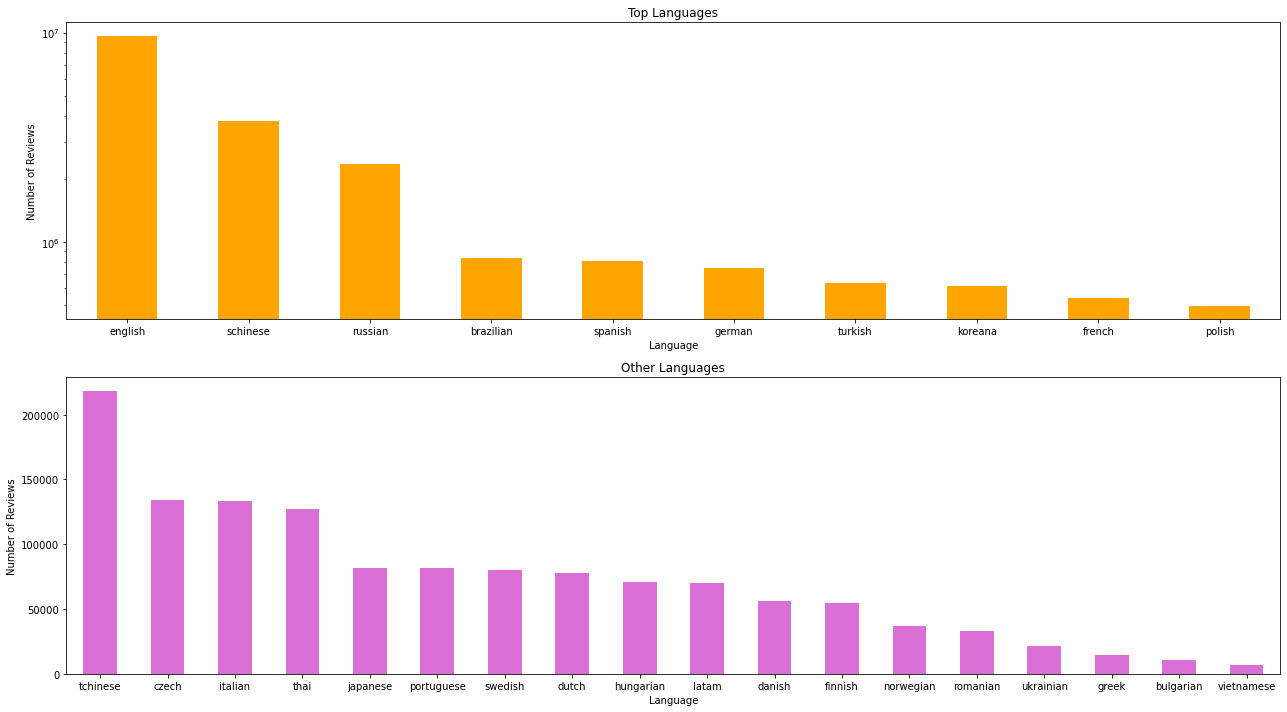

In [154]:
fig=plt.figure(figsize=(25,18))
ax1=fig.add_subplot(2,1,1)
dataset['language'].value_counts().head(10).plot.bar(figsize = (18, 10),title='Top Languages',xlabel='Language',ylabel='Number of Reviews', ax = ax1,rot=0, logy = True, color = "orange")
ax2=fig.add_subplot(2,1,2)
dataset['language'].value_counts().iloc[-18:].plot.bar(figsize = (18, 10),title='Other Languages',xlabel='Language',ylabel='Number of Reviews', ax = ax2,rot=0, color = "orchid")
fig.tight_layout();

#dataset['language'].value_counts().plot.bar(figsize = (18, 7),title='Top Languages',xlabel='Language',ylabel='Number of Reviews', ax = ax1)

# RQ2

### Number of reviews for each application in descending order.

We have decided to make a barplot in which we have counted the number of reviews for the first 50 applications. We have decided 50 because it have seemed to us a good tradeoff to have a clean representation a pick the more reviewed games

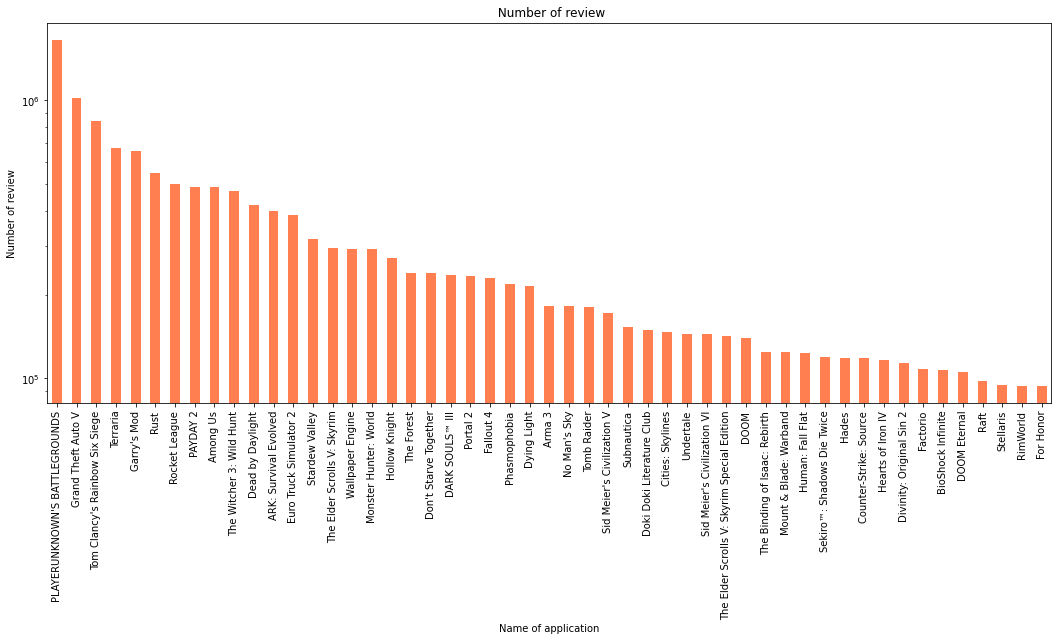

In [19]:
number_review = dataset.groupby("app_name").review_id.count().sort_values(ascending=False)
number_review[0:51].plot.bar(figsize = (18, 7), title=' Number of review', xlabel='Name of application',
ylabel='Number of review', color = "coral", logy = True)
plt.show()


### Best Weighted Vote Score

Each review has a **Weighted Vote Score** that represents the helpfuness score of that review. To extract the weighted  vote score for each game we have computed the mean between all the vote for each application. In this way we have an idea about what applications have received the most helpfulness reviews. Then we have decided to select only average votes above 0.3 because we have considered it a good threshold for the best votes.   

In [8]:
medie = pd.DataFrame(dataset.groupby("app_name").weighted_vote_score.mean().sort_values(ascending=False))
medie = medie[medie.values > 0.3]
medie

,weighted_vote_score
app_name,
Hunt Down The Freeman,0.502150
Urban Empire,0.438623
METAL GEAR SURVIVE,0.421632
Identity,0.415384
Umbrella Corps,0.414678
Torment: Tides of Numenera,0.411199
BERSERK and the Band of the Hawk,0.397092
DRAGON QUEST HEROES™ II,0.381110
X Rebirth,0.380447


### Which applications have the most and the least recommendations

Just to start we have just selected the ten applications that have more and less number of positive recommendations. 

In [9]:
#Most
most = pd.DataFrame(dataset[(dataset.recommended == True)].groupby("app_name").recommended.count().sort_values(ascending=False)).rename(columns={'recommended': 'positive rec'})
most.iloc[:10]



,positive rec
app_name,
PLAYERUNKNOWN'S BATTLEGROUNDS,886417
Grand Theft Auto V,831311
Tom Clancy's Rainbow Six Siege,742397
Terraria,658741
Garry's Mod,632558
Rust,468892
Among Us,463287
The Witcher 3: Wild Hunt,460252
Rocket League,449464


In [10]:
#Least
most.iloc[-10:]

,positive rec
app_name,
Down To One,797
Urban Empire,759
Umbrella Corps,707
Hunt Down The Freeman,689
Rapture Rejects,672
Out of the Park Baseball 19,594
Shadow Complex Remastered,587
Identity,439
DRAGON QUEST HEROES™ II,423


After extracting the absolute values we have decided to compute the relative values of number of positive recommendations. We have done that computing for each application the ratio between positive recommendation and total number of reviews. This kind of operation have seemed more meaningful to us

In [11]:
total_recom = dataset.groupby('app_name')['recommended'].count().reset_index()

positive_recom = dataset[(dataset.recommended == True)].groupby('app_name')['recommended'].count().reset_index()

positive_recom = positive_recom.rename(columns={'app_name': 'app_name', 'recommended': 'rec_True'})

dataset_12= positive_recom.merge(total_recom, left_on = 'app_name', right_on = 'app_name')

dataset_12['percent_True'] = dataset_12['rec_True'] / dataset_12['recommended']



In [12]:
dataset_12 = dataset_12.sort_values(by=["percent_True"], ascending = False).reset_index(drop = True)

most_2 = dataset_12.iloc[0:10]

least_2 = dataset_12.iloc[-10:]

most_2

,app_name,rec_True,recommended,percent_True
0,ULTRAKILL,5558,5584,0.995344
1,Senren＊Banka,5004,5034,0.994041
2,A Short Hike,5797,5847,0.991449
3,The Henry Stickmin Collection,19211,19400,0.990258
4,Factorio,107111,108282,0.989186
5,Hades,117085,118416,0.988760
6,Portal 2,229470,232329,0.987694
7,People Playground,25995,26319,0.987690
8,Townscaper,7503,7601,0.987107
9,Half-Life: Alyx,50428,51099,0.986869


Just to visualize this table we have made a plot in which we can see the ratio between positive recommendation and total recommendations of games and in addition we can have also an idea of their absolute value. Not all games have the same number of recommendations!

Text(0, 0.5, 'number reviews')

/Users/michele/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65290 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/michele/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65290 missing from current font.
  font.set_text(s, 0, flags=flags)


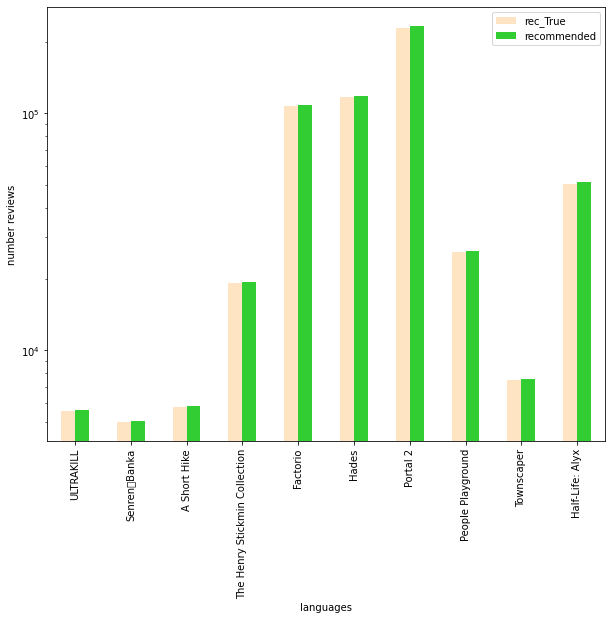

In [13]:
ax = most_2.plot(x = "app_name", y = ["rec_True", "recommended"], kind ='bar', stacked = False, figsize =(10,8), alpha=1, rot=90, color =["bisque","limegreen"])
ax.set_yscale('log')
ax.set_xlabel('languages')
ax.set_ylabel("number reviews")

In [14]:
least_2

,app_name,rec_True,recommended,percent_True
305,Down To One,797,2101,0.379343
306,NBA 2K21,5518,15735,0.350683
307,Deus Ex: The Fall,1243,3610,0.344321
308,Urban Empire,759,2300,0.330000
309,DYNASTY WARRIORS 9,2438,7807,0.312284
310,NBA 2K18,5465,18718,0.291965
311,Umbrella Corps,707,2505,0.282236
312,SOS,1921,6900,0.278406
313,RollerCoaster Tycoon World,1300,5304,0.245098
314,Identity,439,1804,0.243348


We do the same kind of plot for games that have the smaller ratio between positive recommendation and total recommendation

Text(0, 0.5, 'number reviews')

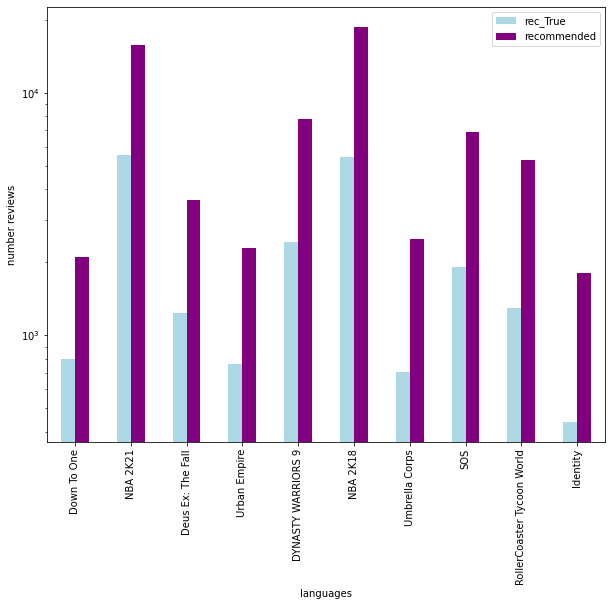

In [17]:
ax = least_2.plot(x = "app_name", y = ["rec_True", "recommended"], kind ='bar', stacked = False, figsize =(10,8), alpha=1, rot=90, color = ["lightblue","purple"])
ax.set_yscale('log')
ax.set_xlabel('languages')
ax.set_ylabel("number reviews")

We can see that if we consider the absolute or relative value of positive recommendations we extract different games. When we consider the absolute value there are some games that have an high number of positive recommendations but also not positive ones so they are in the both list.

### How many of these applications were purchased, and how many were given for free?

Among applications that have the major and the minor *relative* number of positive recommendations we have observed for each application the number of copies that are received for free and the one which are not. We have used only the column **received_for_free** because we have thought that if in this column there is a **True** the game is received for free if instead there is **False** the game is purchased. 

We have considered games that have more positive recommendations relative to their number of reviews and not considered games that have more positive recommendations in absolute value because we have thought that in this way the dataframe that we will obtain are more meaningful.

In [16]:
most_1 = list(most_2.app_name)
new_data = dataset[(dataset["app_name"].isin(most_1))]
pd.DataFrame(new_data.groupby(["app_name", "received_for_free"]).received_for_free.count())

received_for_free
app_name                      received_for_free                   
A Short Hike                  False                           5748
                              True                              99
Factorio                      False                         107140
                              True                            1142
Hades                         False                         117427
                              True                             989
Half-Life: Alyx               False                          48398
                              True                            2701
People Playground             False                          25225
                              True                            1094
Portal 2                      False                         226550
                              True                            5779
Senren＊Banka                  False                           4985
                              True                              49
The Henry Stickmin Collection False                          18863
                              True                             537
Townscaper                    False                           7526
                              True                              75
ULTRAKILL                     False                           5480
                              True                             104

In [74]:
least_1 = list(least_2.app_name)
new_data_2 = dataset[(dataset["app_name"].isin(least_1))]
pd.DataFrame(new_data_2.groupby(["app_name", "received_for_free"]).received_for_free.count())

received_for_free
app_name                   received_for_free                   
DYNASTY WARRIORS 9         False                           7542
                           True                             265
Deus Ex: The Fall          False                           3586
                           True                              24
Down To One                False                           2049
                           True                              52
Identity                   False                           1764
                           True                              40
NBA 2K18                   False                          18505
                           True                             213
NBA 2K21                   False                          15493
                           True                             242
RollerCoaster Tycoon World False                           5243
                           True                              61
SOS                        False                           6599
                           True                             301
Umbrella Corps             False                           2332
                           True                             173
Urban Empire               False                           2277
                           True                              23

In [71]:
#new_data[new_data.received_for_free == True].groupby("app_name").received_for_free.count()

In [72]:
#Most
#most_1 = list(most.index)
#new_data = new_data[(new_data["app_name"].isin(most_1))]
#pd.DataFrame(new_data.groupby(["app_name", "received_for_free"]).recommended.count())

In [73]:
#Least
#least_1 = list(least.index)
#new_data1 = new_data1[(new_data1["app_name"].isin(least_1))]
#pd.DataFrame(new_data1.groupby(["app_name", "received_for_free"]).recommended.count())

# RQ 3

Using the function **orario** we can extract for a given list of time interval the number of reviews written in each time interval 

In [30]:
intervalli = ['06:00:00', '10:59:59', '11:00:00', '13:59:59', '14:00:00', '16:59:59',
        '17:00:00', '19:59:59', '20:00:00', '23:59:59', '00:00:00', '02:59:59', '03:00:00',
        '05:59:59']

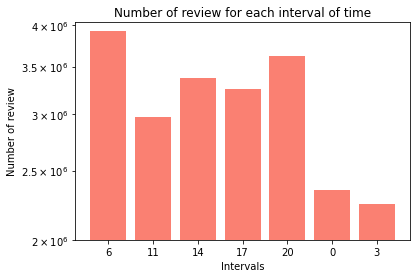

In [176]:
orario(intervalli)

On the x-axis for each bar is indicated the starting point of the time interval. We have observed that fewer people have written reviews during the night while the majority of people have written their reviews in the first hours of the morning and in the dinner hours

# RQ4

### What are the top 3 languages used to review applications?

In [177]:
top_languages = pd.DataFrame(dataset.groupby("language").review_id.count().sort_values(ascending=False).head(3))
top_languages

,review_id
language,
english,9635437
schinese,3764967
russian,2348900


As expected the majority of the reviews are written in english, chinese and russian!

In [178]:
top_languages = list(top_languages.index)
top_languages

['english', 'schinese', 'russian']

### Create a function that receives as parameters both the name of a data set and a list of languages’ names and returns a data frame filtered only with the reviews written in the provided languages.

There we have used the function **filtro** to accomplish a dataframe where there are only reviews written in the top 3 languages

In [ ]:
dataset_filter = filtro(dataset, top_languages)
dataset_filter

### Use the function created in the previous literal to find what percentage of these reviews (associated with the top 3 languages) were voted as funny?

For this request we have used the new filtered dataset and for each language we have selected the reviews that have received at least one funny vote and then we have computed the ratio between them and all the reviews written in that language.

To compute this percentage we have used **dataset_filter** that is the new dataframe obtained using the previous function **filtro**

In [94]:
numeratore = []
denominatore = []
rapporto = []
for i in range(len(top_languages)):
    numeratore.append(dataset_filter[(dataset_filter.votes_funny != 0) & (dataset_filter.language == top_languages[i])].votes_funny.count())
    denominatore.append(dataset_filter[dataset_filter.language == top_languages[i]].votes_funny.count())
    rapporto.append(round((numeratore[i]/denominatore[i])*100, 2))
    print("The percentage of reviews written in ",'\033[1m' +top_languages[i]+'\033[0m'," that has received at least a funny vote is "'\033[1m' +str(rapporto[i])+"%"+'\033[0m')
    


The percentage of reviews written in  english  that has received at least a funny vote is 11.27%
The percentage of reviews written in  schinese  that has received at least a funny vote is 11.82%
The percentage of reviews written in  russian  that has received at least a funny vote is 16.68%


At this point we have also wanted to compute the percentage of reviews that have received at least a funny vote among all these three languages. 

In [78]:
num = dataset_filter[dataset_filter.votes_funny != 0].votes_funny.count()
den = dataset_filter.votes_funny.count()
print("The percentage of reviews written in one of the top 3 language that has received at least a funny vote is ", '\033[1m' +str(round((num/den)*100, 2))+"%"+'\033[0m')



The percentage of reviews written in one of the top 3 language that has received at least a funny vote is  12.21%


### Use the function created in the literal “a” to find what percentage of these reviews (associated with the top 3 languages) were voted as helpful?

For this request we have used the new filtered dataset and for each language we have selected the reviews that have received at least one helpful vote and then we have computed the ratio between them and all the reviews written in that language.

To compute this percentage we have used **dataset_filter** that is the new dataframe obtained using the previous function **filtro**

In [96]:
numeratore = []
denominatore = []
rapporto = []
for i in range(len(top_languages)):
    numeratore.append(dataset_filter[(dataset_filter.votes_helpful != 0) & (dataset_filter.language == top_languages[i])].votes_helpful.count())
    denominatore.append(dataset_filter[dataset_filter.language == top_languages[i]].votes_helpful.count())
    rapporto.append(round((numeratore[i]/denominatore[i])*100, 2))
    print("The percentage of reviews written in ",'\033[1m' +top_languages[i]+"%"+'\033[0m'+ " that has received at least a helpful vote is ",'\033[1m' +str(rapporto[i])+"%"+'\033[0m'+"%")



The percentage of reviews written in  english% that has received at least a helpful vote is  29.2%%
The percentage of reviews written in  schinese% that has received at least a helpful vote is  25.1%%
The percentage of reviews written in  russian% that has received at least a helpful vote is  35.5%%


At this point we have also wanted to compute the percentage of reviews that have received at least a helpful vote among all these three languages.

In [97]:
num = dataset_filter[dataset_filter.votes_helpful != 0].votes_helpful.count()
den = dataset_filter.votes_helpful.count()
print("The percentage of reviews written in one of the top 3 language that has received at least a helpful vote is ", '\033[1m' +str(round((num/den)*100, 2))+"%"+'\033[0m')


The percentage of reviews written in one of the top 3 language that has received at least a helpful vote is  29.16%


# RQ6 


### What is the average time (days and minutes) a user lets pass before he updates a review?

Just to start we have computed the difference between the time when the review is written and time when the review is updated and then we have transformed this difference in terms of days

In [44]:
dataset['Difference_Days'] = (dataset['timestamp_updated'] - dataset['timestamp_created'])
dataset['Difference_Days'] = dataset['Difference_Days']/np.timedelta64(1,'D')


After that we have deleted who did not update his review because we have thought that is meaningless consider them. Then we have computed the mean between days and the integer part of this number represents the average number of days after an author updates his review. Instead to transform the decimal part in minutes we have to multiply it for 1440 because in one day there are 1440 minutes. We have made a simple proportion: *1 : 1440 = x : (decimal part of our number)*

In [98]:
dataset_1 = dataset[dataset.Difference_Days != 0]
average = dataset_1.Difference_Days.mean()
minutes = round((average % 1) * 1440, 0)
days = average // 1
print("The average time a user lets pass before he updates a review is ",'\033[1m' +str(days)+'\033[0m' +" days and ",'\033[1m' +str(minutes)+'\033[0m' +" minutes")



The average time a user lets pass before he updates a review is  321.0 days and  46.0 minutes


On average an author updates his review almost after a year! 

### Plot the top 3 authors that usually update their reviews.

We have used the dataframe **dataset_1** in which there are only the reviews that have been updated. We did not use the starting dataset because we have to extract who are the authors that usually update their reviews so authors that have updated more reviews through time.

In [49]:
a = pd.Series(dataset_1.groupby('author.steamid').review_id.count().sort_values(ascending=False).head(3))
a

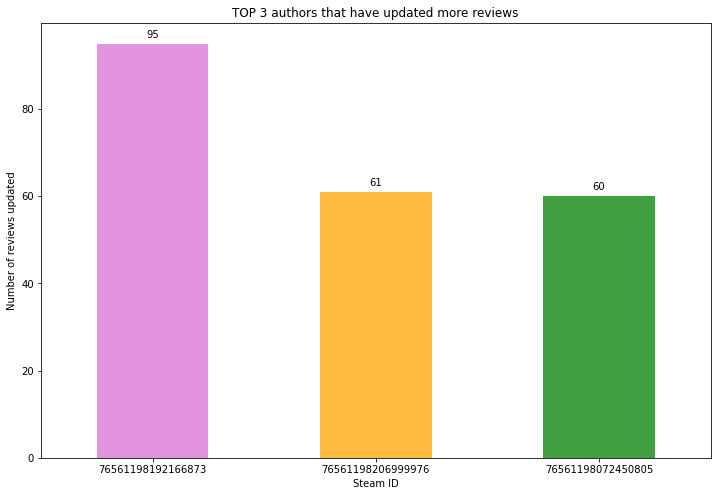

In [132]:
plt.figure(figsize=(12, 8))
ax = a.plot(kind="bar", color = ["orchid", "orange", "green"], alpha=0.75, rot=0)
ax.set_title("TOP 3 authors that have updated more reviews")
ax.set_xlabel("Steam ID")
ax.set_ylabel("Number of reviews updated")
labels = list(a.values)
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 1, label, ha="center", va="bottom"
    )

We have put the number of reviews over the bars because the second and the third author have updated almost the same number of reviews.

# RQ7


### What’s the probability that a review has a Weighted Vote Score equal to or bigger than 0.5

We have used the definition of probability to compute these values indeed we have count the number of reviews that has a Weighted Vote Score equal to or bigger than 0.5 and this number represents the favourable case (we have stored this number in **casi_fav**)while the number of total case is represented by the number of the lines of our dataset, stored in **casi_tot**. The probability is the ratio between them. 

In [83]:
casi_fav = dataset[dataset.weighted_vote_score >= 0.5].weighted_vote_score.count()
casi_fav

4784092

In [84]:
casi_tot = dataset.weighted_vote_score.count()

In [86]:
result_1 = round(casi_fav/casi_tot, 2)
print("The probability is of a review has a Weighted Vote Score equal to or bigger than 0.5 is "+ '\033[1m' +str(result_1)+'\033[0m')

The probability is of a review has a Weighted Vote Score equal to or bigger than 0.5 is 0.22


### What’s the probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5?

To compute this conditional probability my sample sample will be reduced indeed we have filtered the dataset in such way that we are going to look for reviews with at least one vote as funny just among reviews with Weighted Vote Score is bigger than 0.5.

In [87]:
dataset_prob = dataset[dataset.weighted_vote_score > 0.5]

In [88]:
casi_fav_2 = dataset_prob[dataset_prob.votes_funny != 0].votes_funny.count()


Now our sample space in other words the total case are the favourable case used to compute the last probability, **case_fav**: number of reviews that has a Weighted Vote Score equal to or bigger than 0.5

In [89]:
result_2 = round(casi_fav_2/casi_fav, 2)
print("The conditional probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5 is ",'\033[1m' +str(result_2)+'\033[0m')



The conditional probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5 is  0.24


### Is the probability that “a review has at least one vote as funny” independent of the “probability that a review has a Weighted Vote Score equal or bigger than 0.

To be independent these two events it would happen that the probability of the event: *a review has at least one vote as funny* would be equal to *probability that a review has at least one vote as funny given that the Weighted Vote Score is bigger than 0.5* because in this way the conditioning of the two probability is useless given that they are independent. 

In [90]:
casi_fav_3 = dataset[dataset.votes_funny != 0].votes_funny.count()


In [92]:
result_3 = round(casi_fav_3/casi_tot,2)
print("The probability of a review has at least one vote as funny is "+ '\033[1m' +str(result_3)+'\033[0m')

The probability of a review has at least one vote as funny is 0.12


0.12 is different from 0.24 so these two events are **dependent!**